In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import efficientnet_b0, efficientnet_v2_s, vit_b_16, vit_b_32
from torchvision.models import EfficientNet_B0_Weights, EfficientNet_V2_S_Weights, ViT_B_16_Weights, ViT_B_32_Weights
import torchvision.transforms as transforms
from torchinfo import summary

from sklearn.model_selection import StratifiedShuffleSplit

from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

# CUDA

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
assert device.type == "cuda", "Ahh, stop there, you need a GPU for training this model."

Using device: cuda


# Prepare Dataset

In [4]:
dataset_path = "./data/cat_dog/"
cat_dog_csv = pd.read_csv(os.path.join(dataset_path, "cat_dog.csv"))
# print(cat_dog_csv.head())
img_name, labels = [], []
for i in range(len(cat_dog_csv)):
    img_name.append(cat_dog_csv.iloc[i, 0])
    labels.append(cat_dog_csv.iloc[i, 1])

img_all = []
for i in range(len(img_name)):
    img_path = os.path.join(dataset_path, "cat_dog", img_name[i])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img_all.append(img)

img_all = np.array(img_all) / 255.0
labels = np.array(labels)

In [5]:
class CatDogDataset(Dataset):
    def __init__(self, images, labels, idx, transform=None):
        self.images = images
        self.labels = labels
        self.idx = idx
        self.transform = transform

    def __len__(self):
        return len(self.idx)
    
    def __getitem__(self, idx):
        img = self.images[self.idx[idx]]
        label = self.labels[self.idx[idx]]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [6]:
train_idx, val_test_idx = next(
    StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(img_all, labels)
)
val_test_Y = labels[val_test_idx]
val_idx_pre, test_idx_pre = next(
    StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42).split(val_test_idx, val_test_Y)
)
val_idx, test_idx = val_test_idx[val_idx_pre], val_test_idx[test_idx_pre]

In [7]:
# Train Transform: random horizontal flip, random rotation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test Transform: resize and normalize
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataloaders

In [8]:
train_dataset = CatDogDataset(img_all, labels, train_idx, transform=train_transform)
val_dataset = CatDogDataset(img_all, labels, val_idx, transform=val_test_transform)
test_dataset = CatDogDataset(img_all, labels, test_idx, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=192, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=192, shuffle=False, num_workers=16)

# Modified Models

In [9]:
class PredictionHead(nn.Module):
    def __init__(self, feature_dims):
        super(PredictionHead, self).__init__()
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.fc = nn.Sequential()
        for i in range(len(feature_dims)-1):
            # self.fc.add_module(f'drop_{i}', self.dropout)
            self.fc.add_module(f'fc_{i}', nn.Linear(feature_dims[i], feature_dims[i+1]))
            if i != len(feature_dims)-2:
                self.fc.add_module(f'a_{i}', self.activate)

    def forward(self, x):
        x = self.fc(x)

        return x

In [10]:
def new_custom_effb0(hidden_features):
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    feature = [1280]
    feature.extend(hidden_features)
    model.classifier = PredictionHead(feature).cuda()
    
    model = model.to(device)
    return model

def new_custom_vit_b32(hidden_features):
    model = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)
    feature = [768]
    feature.extend(hidden_features)
    model.heads = PredictionHead(feature).cuda()
    
    model = model.to(device)
    return model

def new_custom_vit_b16(hidden_features):
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    feature = [768]
    feature.extend(hidden_features)
    model.heads = PredictionHead(feature).cuda()
    
    model = model.to(device)
    return model

In [11]:
# model = new_custom_effb0([512, 128, 32, 1])
# model = new_custom_vit_b32([512, 128, 32, 1])

# summary(model, input_size=(32, 3, 224, 224), device=device)

In [14]:
# LR = 3e-4 # eff
LR = 8e-5 # vit
NUM_EPOCHES = 5
SUB_EPOCHES = 4
# GAMMA = 0.75 # eff
GAMMA = 0.85 # vit
arch = "vit_b16"
head_features = [512, 128, 32, 1]

model_function = {
    "effb0": new_custom_effb0,
    "vit_b32": new_custom_vit_b32,
    "vit_b16": new_custom_vit_b16
}
model = model_function[arch](head_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [15]:
avg_train_loss, avg_val_loss = [], []
for i in range(NUM_EPOCHES):
    model.train()
    print("-"*80)
    # print(f"Learning Rate: {scheduler.get_last_lr()[0]:.8f}")
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {i+1}/{NUM_EPOCHES}', unit='batch')
    n = 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output.squeeze(), y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix({'loss': loss.item(), 'learning_rate': scheduler.get_last_lr()[0]})
        n += 1
        if n >= round(len(pbar)/SUB_EPOCHES):
            scheduler.step()
            n = 0

    train_loss /= len(train_loader)
    avg_train_loss.append(train_loss)

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for x, y in tqdm(val_loader, desc='Validation', unit='batch'):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output.squeeze(), y.float())
            val_loss += loss.item()
        
        avg_val_loss.append(val_loss / len(val_loader))
    print(f'Train Loss: {avg_train_loss[-1]:.4f}, Validation Loss: {avg_val_loss[-1]:.4f}')
    print("-"*80)
    print()

--------------------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.54batch/s]


Train Loss: 0.1094, Validation Loss: 0.0269
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.50batch/s]


Train Loss: 0.0208, Validation Loss: 0.0259
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.49batch/s]


Train Loss: 0.0082, Validation Loss: 0.0196
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.51batch/s]


Train Loss: 0.0041, Validation Loss: 0.0220
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:05<00:00,  2.48batch/s]

Train Loss: 0.0028, Validation Loss: 0.0200
--------------------------------------------------------------------------------



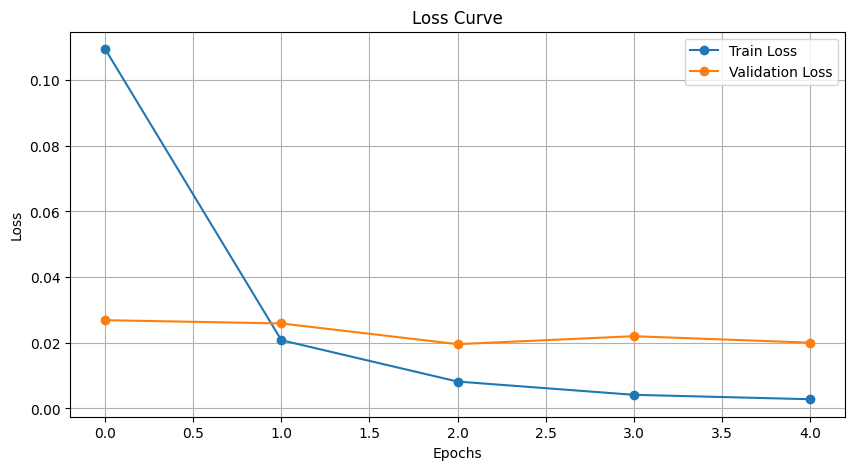

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(avg_train_loss, label='Train Loss', marker='o')
plt.plot(avg_val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [17]:
torch.save(model.state_dict(), f'./model/cat_dog_{arch}.pth')

In [18]:
best_model = model_function[arch](head_features)
best_model.load_state_dict(torch.load(f'./model/cat_dog_{arch}.pth'))

<All keys matched successfully>

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    accuracy = np.trace(cm) / np.sum(cm)
    print("Accuracy: ", accuracy)

Testing: 100%|██████████| 14/14 [00:06<00:00,  2.16batch/s]


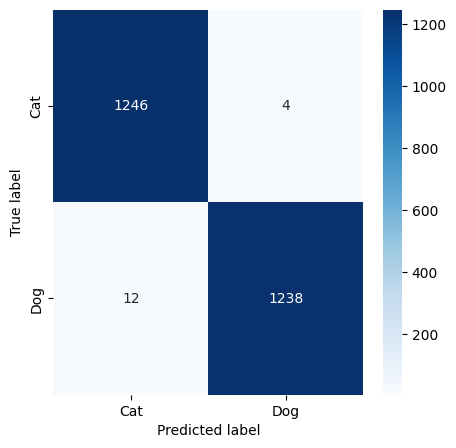

Accuracy:  0.9936


In [20]:
y_true_test = []
y_pred_test = []
for x, y in tqdm(test_loader, desc='Testing', unit='batch'):
    x = x.to(device)
    with torch.no_grad():
        output = best_model(x)
        output = torch.sigmoid(output).cpu().numpy()
        y_pred_test.extend(output.squeeze())
        y_true_test.extend(y.numpy())
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
y_pred_test = (y_pred_test > 0.5).astype(int)
plot_confusion_matrix(y_true_test, y_pred_test, classes=['Cat', 'Dog'])